<a href="https://colab.research.google.com/github/Jacob105/Deep-Learning/blob/main/GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

# List files to confirm the name of the downloaded file
!ls

# Unzip the dataset (adjust the filename if necessary)
import zipfile

# Replace 'face-expression-recognition-dataset.zip' with the correct file name if different
with zipfile.ZipFile("gender-classification-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("gender-classification-dataset")

Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset
License(s): other
100% 269M/269M [00:13<00:00, 23.9MB/s]
100% 269M/269M [00:13<00:00, 21.4MB/s]
gender-classification-dataset.zip  kaggle.json	sample_data


# Displaying Images

In [ ]:
picture_size = 48
folder_path_train = "/content/gender-classification-dataset/Training/"
folder_path_val = "/content/gender-classification-dataset/Validation/"

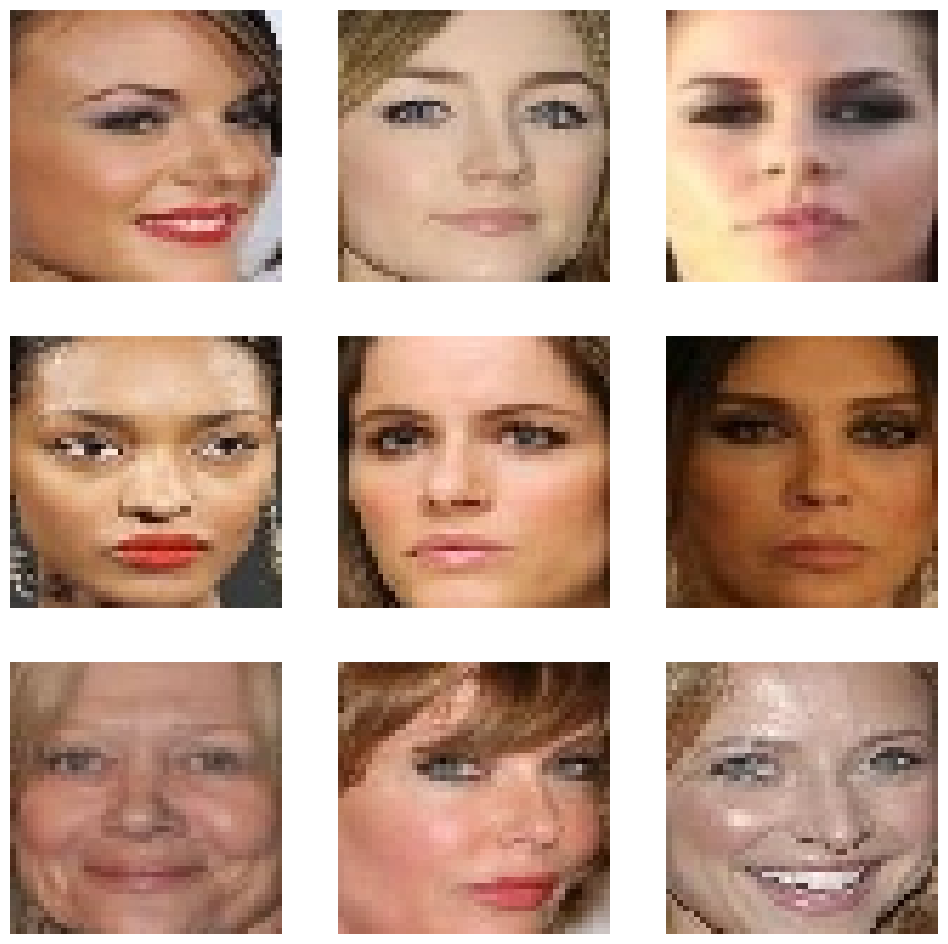

In [ ]:
gender_path = 'female'

# Construct the full path to the expression directory
gender_path = os.path.join(folder_path_train, gender_path)

# Verify if the folder exists
if not os.path.exists(gender_path):
    raise FileNotFoundError(f"The path {gender_path} does not exist.")

# Get the list of images in the directory
image_files = os.listdir(gender_path)
if len(image_files) == 0:
    raise FileNotFoundError(f"No files found in the directory {gender_path}")

plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)

    # Ensure that the index i is within the range of available images
    if i >= len(image_files):
        print(f"Warning: Not enough images in the directory. Only {len(image_files)} images found.")
        break

    img_path = os.path.join(gender_path, image_files[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better display

plt.show()

# Making Training and Validation Data

In [ ]:
# Define the paths to your train and validation directories
train_dir = os.path.join(folder_path_train)
validation_dir = os.path.join(folder_path_val)

# Define picture size and batch size
picture_size = 48
batch_size = 128

# Define data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

# Flow from directory for training set
train_set = datagen_train.flow_from_directory(
    train_dir,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='binary',  # Changed to binary for binary classification
    shuffle=True
)

# Flow from directory for validation set
test_set = datagen_val.flow_from_directory(
    validation_dir,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='binary',  # Changed to binary for binary classification
    shuffle=False
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


# Model Building

In [ ]:
model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd CNN layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fully connected 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

# Fitting the Model with Training and Validation Data

In [ ]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=2,
                                        verbose=1,
                                        min_delta=0.0001)
learning_rates = [0.01, 0.001, 0.0001]



callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Set the number of epochs
epochs = 48

# Compile the model



In [ ]:
history = model.fit(
    x=train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)

Epoch 1/48
367/367 [==============================] - ETA: 0s - loss: 6.4845 - accuracy: 0.7635
Epoch 1: val_accuracy improved from -inf to 0.49854, saving model to ./model.h5
367/367 [==============================] - 52s 123ms/step - loss: 6.4845 - accuracy: 0.7635 - val_loss: 6.3160 - val_accuracy: 0.4985 - lr: 1.0000e-04
Epoch 2/48


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


367/367 [==============================] - ETA: 0s - loss: 3.2315 - accuracy: 0.8898
Epoch 2: val_accuracy improved from 0.49854 to 0.92119, saving model to ./model.h5
367/367 [==============================] - 44s 119ms/step - loss: 3.2315 - accuracy: 0.8898 - val_loss: 2.2524 - val_accuracy: 0.9212 - lr: 1.0000e-04
Epoch 3/48
367/367 [==============================] - ETA: 0s - loss: 1.6974 - accuracy: 0.9125
Epoch 3: val_accuracy improved from 0.92119 to 0.93613, saving model to ./model.h5
367/367 [==============================] - 44s 119ms/step - loss: 1.6974 - accuracy: 0.9125 - val_loss: 1.2053 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 4/48
367/367 [==============================] - ETA: 0s - loss: 0.9693 - accuracy: 0.9219
Epoch 4: val_accuracy improved from 0.93613 to 0.94531, saving model to ./model.h5
367/367 [==============================] - 43s 118ms/step - loss: 0.9693 - accuracy: 0.9219 - val_loss: 0.7121 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 5/48
367/367 [=

# Plotting Accuracy & Loss

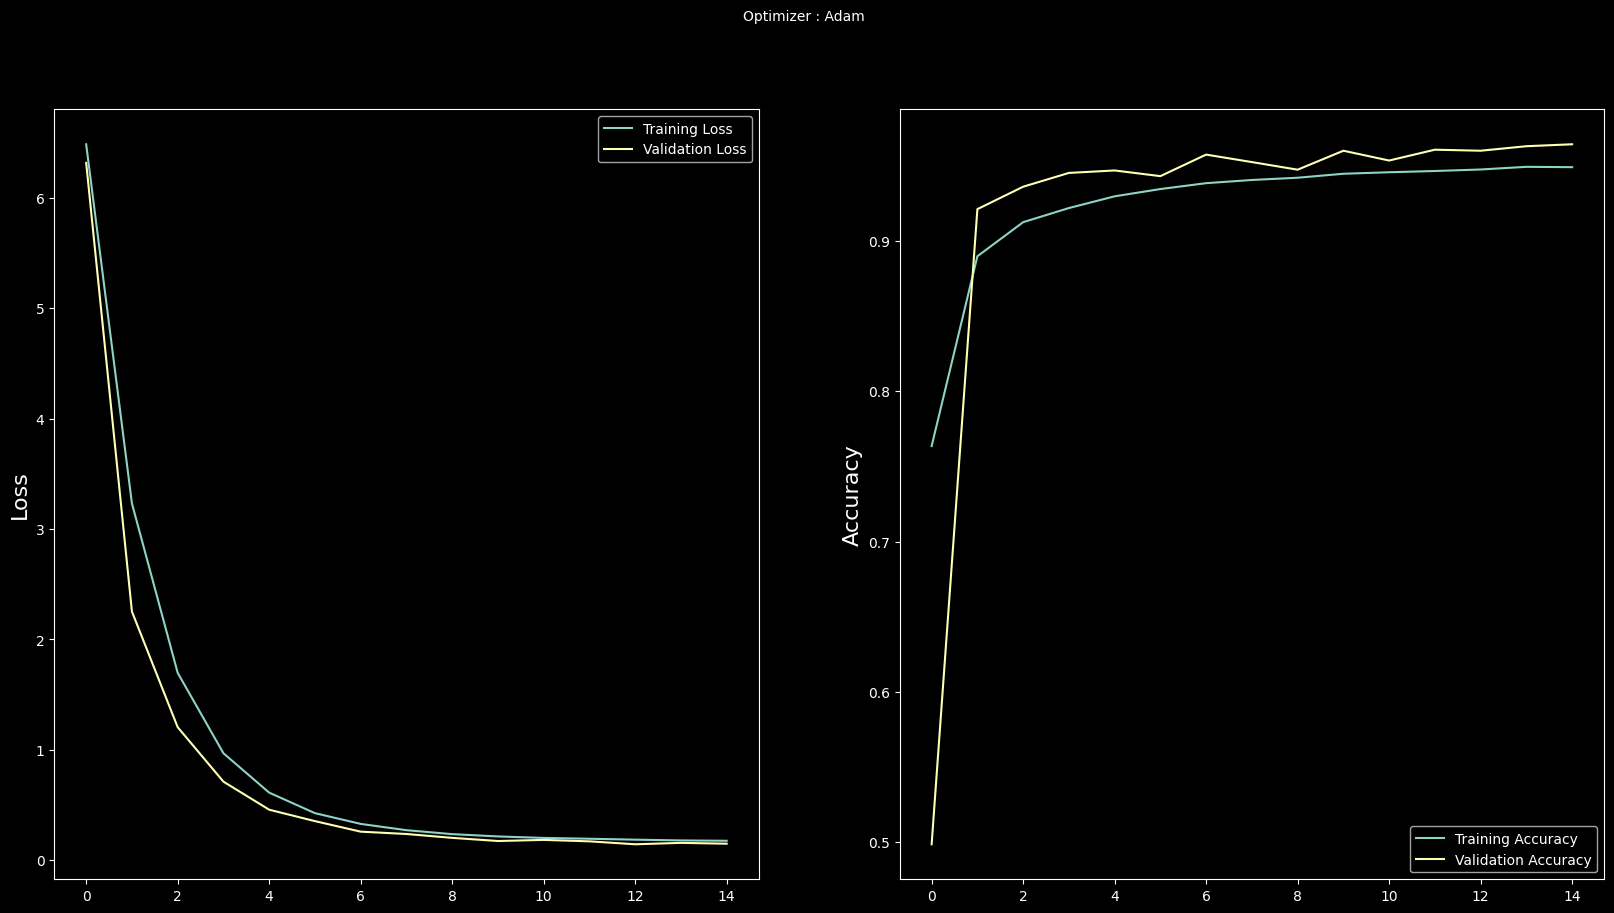

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('model5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
